In [1]:
import numpy as np 
import jax.numpy as jnp
import jax.tree_util as jtu
from jax import vmap, lax
from jax import random as jr
import numpy as np

from pymdp.jax.envs.generalized_tmaze import (
    GeneralizedTMazeEnv, parse_maze, render 
)

from pymdp.jax.agent import Agent as AIFAgent

### Grid world (generalized TMaze) generative process

In this example we create a simple square environment, where multiple cues are present, and multiple reward pairs. Each cue indicates the location of one of the reward pairs. 

The agent is can move in the grid world using actions up, down, left and right, and observes the current tile it is at. 

The grid world is specified by a matrix using the following labels: 

```
0: Empty space
1: The initial position of the agent
2: Walls
3 + i: Cue for reward i
4 + i: Potential reward location i 1
4 + i: Potential reward location i 2
```

In [2]:
def rollout(policy_search, agent, env, num_timesteps, rng_key):
    # get the batch_size of the agent
    batch_size = agent.batch_size

    def step_fn(carry, x):
        observation_t = carry["observation_t"]
        prior = carry["empirical_prior"]
        env = carry["env"]
        rng_key = carry["rng_key"]

        # We infer the posterior using FPI
        # so we don't need past actions or qs_hist
        qs = agent.infer_states(
            observation_t,
            prior
        )
        rng_key, key = jr.split(rng_key)
        qpi = policy_search(key, agent, qs)

        keys = jr.split(rng_key, batch_size + 1)
        rng_key = keys[0]
        action_t = agent.sample_action(qpi, rng_key=keys[1:])

        keys = jr.split(rng_key, batch_size + 1)
        rng_key = keys[0]
        observation_t, env = env.step(rng_key=keys[1:], actions=action_t)

        prior, _ = agent.infer_empirical_prior(action_t, qs)

        carry = {
            "observation_t": observation_t,
            "empirical_prior": prior,
            "env": env,
            "rng_key": rng_key,
        }
        info = {
            "qpi": qpi,
            "qs": jtu.tree_map(lambda x: x[:, 0], qs),
            "env": env,
            "observation": observation_t,
            "action": action_t,
        }

        return carry, info

    # generate initial observation
    keys = jr.split(rng_key, batch_size + 1)
    rng_key = keys[0]
    observation_0, env = env.step(keys[1:])

    initial_carry = {
        "observation_t": observation_0,
        "empirical_prior": agent.D,
        "env": env,
        "rng_key": rng_key,
    }

    # Scan over time dimension (axis 1)
    last, info = lax.scan(step_fn, initial_carry, jnp.arange(num_timesteps))

    info = jtu.tree_map(lambda x: jnp.swapaxes(x, 0, 1), info)
    return last, info, env

2024-06-13 15:52:14.830895: W external/xla/xla/service/gpu/nvptx_compiler.cc:763] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


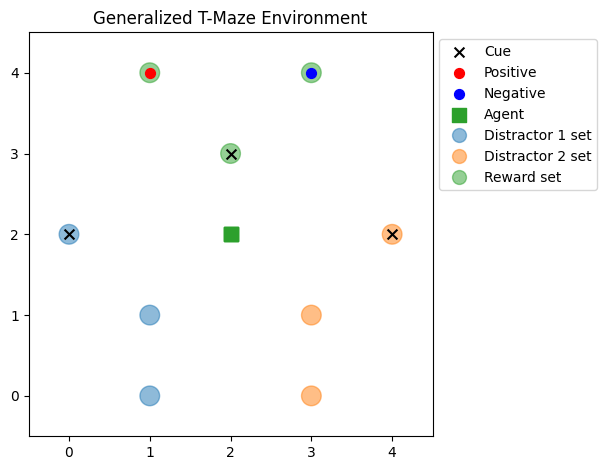

In [3]:
def get_maze_matrix(size='small'):
    if size == 'small':
        M = np.zeros((3, 5))

        # Set the reward locations
        M[0,1] = 4
        M[1,1] = 5
        M[1,3] = 7
        M[0,3] = 8

        # Set the cue locations
        M[2,0] = 3
        M[2,4] = 6

        # Set the initial position
        M[2,3] = 1
    
    elif size == 'medium':
        M = np.zeros((5, 5))

        # Set the reward locations
        M[0,1] = 4
        M[1,1] = 5
        M[1,3] = 7
        M[0,3] = 8
        M[4,1] = 10
        M[4,3] = 11

        # Set the cue locations
        M[2,0] = 3
        M[2,4] = 6
        M[3,2] = 9

        # Set the initial position
        M[2,2] = 1
    
    else:
        M = np.zeros((7, 5))

        # Set the reward locations
        M[0,1] = 4
        M[1,1] = 5
        M[1,3] = 7
        M[0,3] = 8
        M[5,1] = 10
        M[6,1] = 11
        M[5,3] = 13
        M[6,3] = 14

        # Set the cue locations
        M[2,0] = 3
        M[2,4] = 6
        M[4,0] = 9
        M[4,4] = 12

        # Set the initial position
        M[3,2] = 1

    return M

M = get_maze_matrix('medium')
env_info = parse_maze(M)
tmaze_env = GeneralizedTMazeEnv(env_info, batch_size=3)

images = []
images.append( render(env_info, tmaze_env) )

#### Create the agent. 

The PyMDPEnv class consists of a params dict that contains the A, B, and D vectors of the environment. We initialize our agent using the same parameters. This means that the agent has full knowledge about the environment transitions, and likelihoods. We initialize the agent with a flat prior, i.e. it does not know where it, or the reward is. Finally, we set the C vector to have a preference only over the rewarding observation of cue-reward pair 1 (i.e. C[1][1] = 1 and zero for other values). 

In [4]:
A = [a.copy() for a in tmaze_env.params["A"]]
B = [b.copy() for b in tmaze_env.params["B"]]
A_dependencies = tmaze_env.dependencies["A"]
B_dependencies = tmaze_env.dependencies["B"]

# [position], [cue], [reward]
C = [jnp.zeros(a.shape[:2]) for a in A]

rewarding_modality = -1 # 2 + env_info["num_cues"]

C[rewarding_modality] = C[rewarding_modality].at[:, 1].set(1.0)
C[rewarding_modality] = C[rewarding_modality].at[:, 2].set(-2.0)


D = [jnp.ones(b.shape[:2]) / b.shape[1] for b in B]

agent = AIFAgent(
    A, B, C, D, 
    E=None,
    pA=None,
    pB=None,
    policy_len=1,
    A_dependencies=A_dependencies, 
    B_dependencies=B_dependencies,
    use_utility=True,
    use_states_info_gain=True,
    sampling_mode='full'
)

print(B_dependencies)

[[0], [1], [2], [3]]


### MCTS based policy search

In [5]:
import mctx
from tmp_mcts import make_aif_recurrent_fn

max_depth = 6
num_simulations = 4096

def si_policy(rng_key, agent, beliefs):
    
    # remove time dimension 
    embedding = jtu.tree_map(lambda x: x[:, 0], beliefs)
    root = mctx.RootFnOutput(
        prior_logits=jnp.log(agent.E),
        value=jnp.zeros((agent.batch_size)),
        embedding=embedding,
    )

    recurrent_fn = make_aif_recurrent_fn()

    policy_output = mctx.gumbel_muzero_policy(
        agent,
        rng_key,
        root,
        recurrent_fn,
        num_simulations=num_simulations,
        max_depth=max_depth
    )

    return policy_output.action_weights

### Run active inference

In [6]:
timesteps = 12
key = jr.PRNGKey(0)
_, info, _ = rollout(si_policy, agent, tmaze_env, num_timesteps=timesteps, rng_key=key)

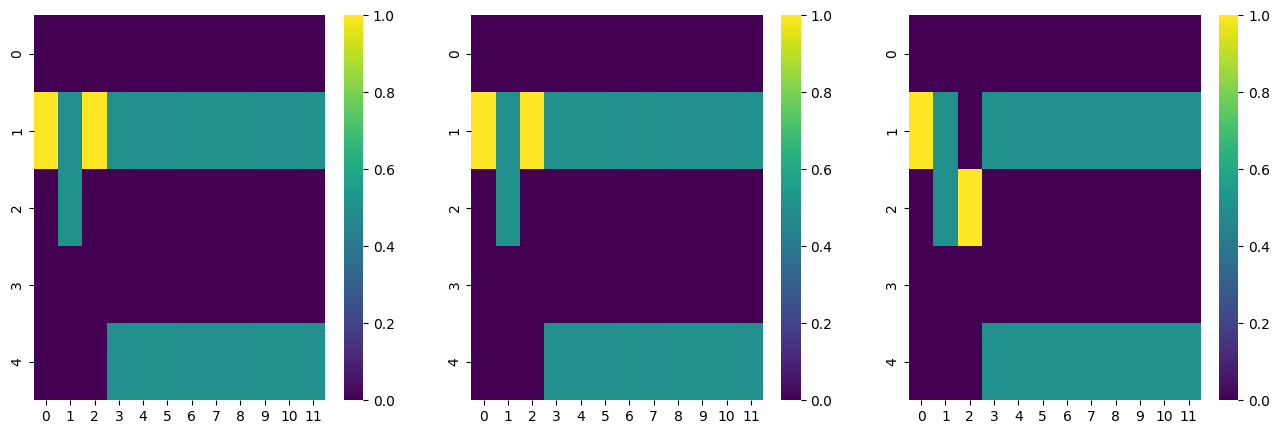

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
for i in range(3):
    sns.heatmap(info['qpi'][i].T, cmap='viridis', ax=axes[i])

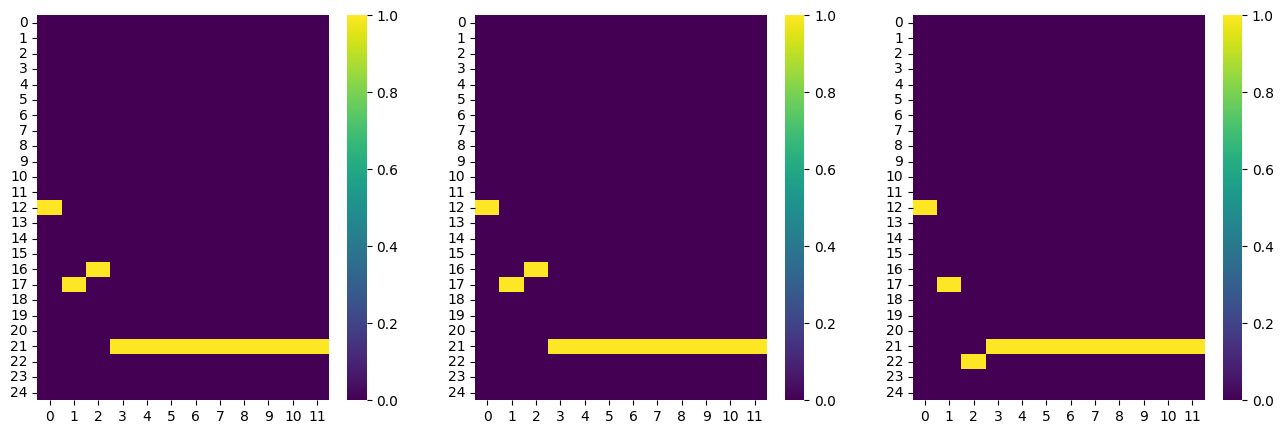

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
for i in range(3):
    sns.heatmap(info['qs'][0][i].T, cmap='viridis', ax=axes[i])

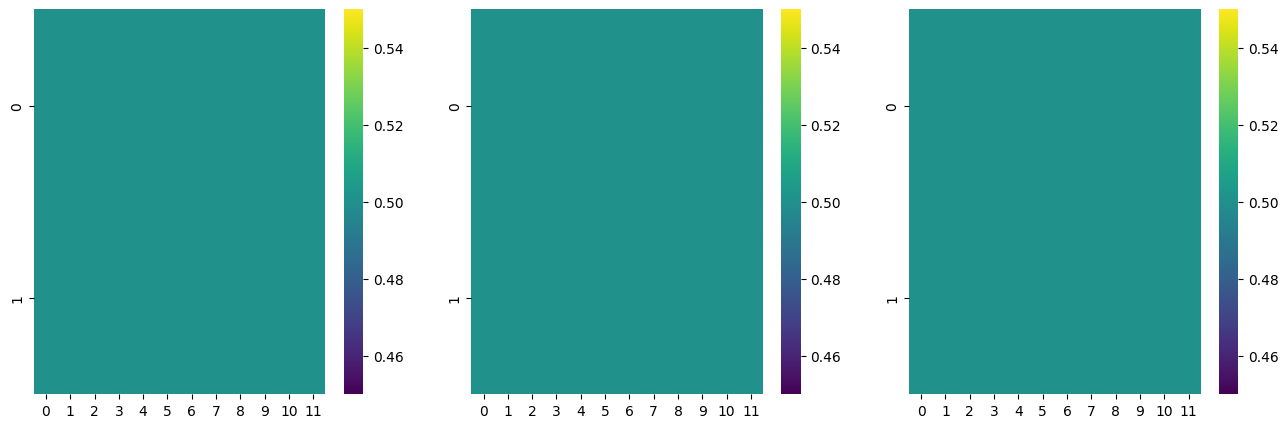

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
for i in range(3):
    sns.heatmap(info['qs'][1][i].T, cmap='viridis', ax=axes[i])

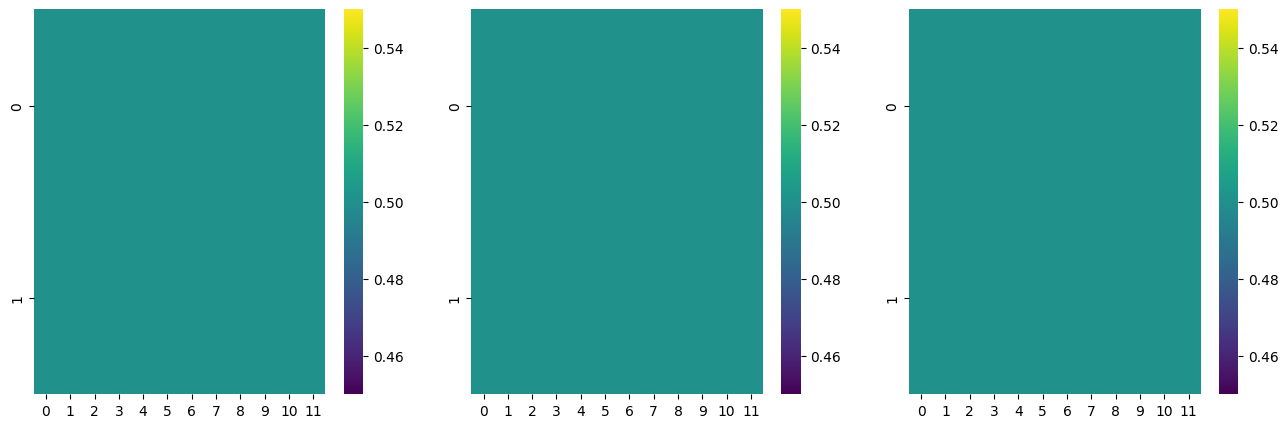

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
for i in range(3):
    sns.heatmap(info['qs'][2][i].T, cmap='viridis', ax=axes[i])

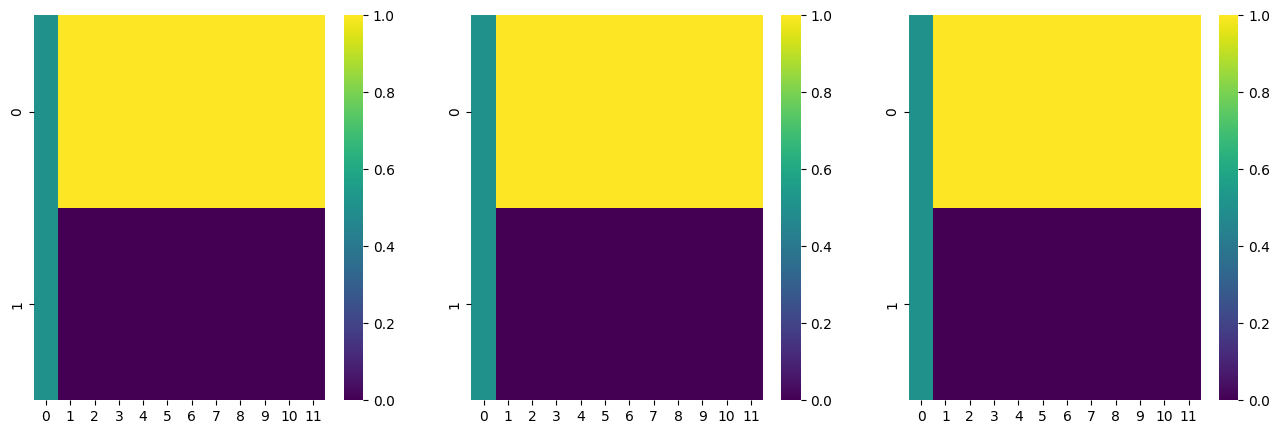

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
for i in range(3):
    sns.heatmap(info['qs'][3][i].T, cmap='viridis', ax=axes[i])

In [12]:
%%capture

for t in range(timesteps): 
    env_state = jtu.tree_map(lambda x: x[:, t], info['env'])
    plt.figure()
    images.append( np.array(render(env_info, env_state, show_img=False)) )

In [13]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

fig, ax = plt.subplots()

sns.despine(fig, left=True, bottom=True)
ax.set_xticks([])
ax.set_yticks([])

# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
frames = []
for i, img in enumerate(images):
    im = ax.imshow(img, animated=True)
    if i == 0:
        ax.imshow(img)  # show an initial one first
    frames.append([im])

ani = animation.ArtistAnimation(fig, frames, interval=1000, blit=True,
                                repeat_delay=1000)

# To save the animation, use e.g.
#
# ani.save("movie.mp4")
#
# or
#
# writer = animation.FFMpegWriter(
#     fps=15, metadata=dict(artist='Me'), bitrate=1800)
# ani.save("movie.mp4", writer=writer)

plt.close(ani._fig)

# Call function to display the animation
HTML(ani.to_html5_video())

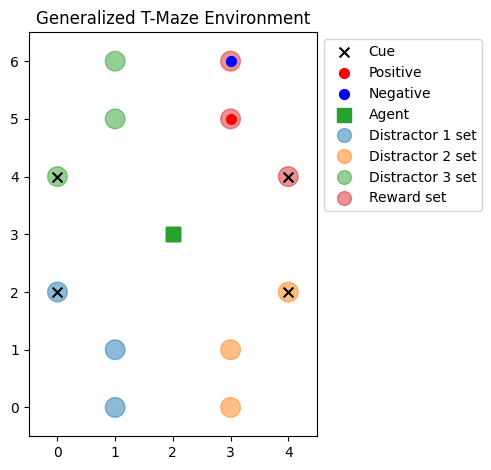

[[0], [1], [2], [3], [4]]


In [14]:
M = get_maze_matrix('large')
env_info = parse_maze(M)
tmaze_env_large = GeneralizedTMazeEnv(env_info, batch_size=3)
images = []
images.append( render(env_info, tmaze_env_large) )

A = [a.copy() for a in tmaze_env_large.params["A"]]
B = [b.copy() for b in tmaze_env_large.params["B"]]
A_dependencies = tmaze_env_large.dependencies["A"]
B_dependencies = tmaze_env_large.dependencies["B"]

# [position], [cue], [reward]
C = [jnp.zeros(a.shape[:2]) for a in A]

rewarding_modality = -1 # 2 + env_info["num_cues"]

C[rewarding_modality] = C[rewarding_modality].at[:, 1].set(1.0)
C[rewarding_modality] = C[rewarding_modality].at[:, 2].set(-2.0)


D = [jnp.ones(b.shape[:2]) / b.shape[1] for b in B]

agent = AIFAgent(
    A, B, C, D, 
    E=None,
    pA=None,
    pB=None,
    policy_len=1,
    A_dependencies=A_dependencies, 
    B_dependencies=B_dependencies,
    use_utility=True,
    use_states_info_gain=True,
    sampling_mode='full'
)

print(B_dependencies)

In [15]:
timesteps = 12
key = jr.PRNGKey(101)
_, info, _ = rollout(si_policy, agent, tmaze_env_large, num_timesteps=timesteps, rng_key=key)

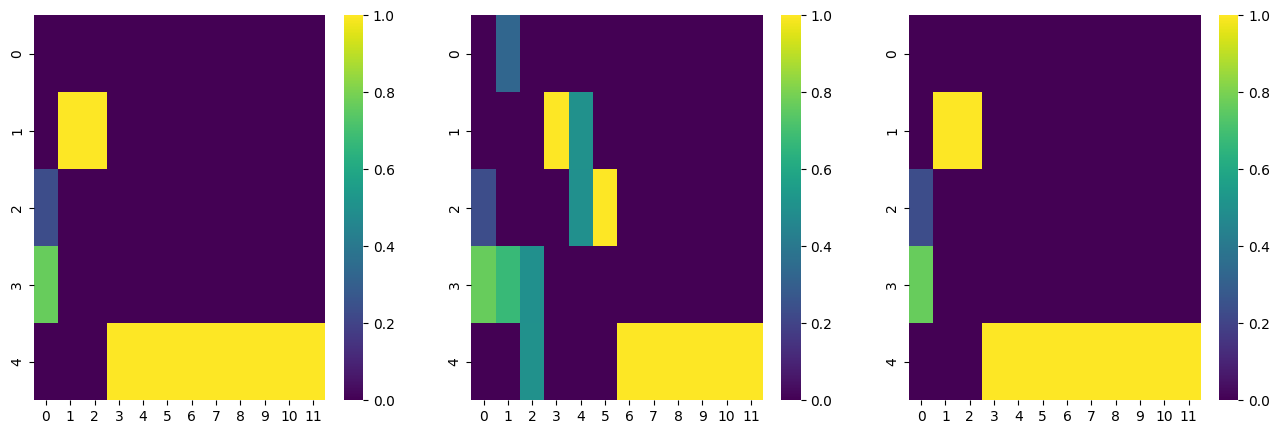

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
for i in range(3):
    sns.heatmap(info['qpi'][i].T, cmap='viridis', ax=axes[i])

In [16]:
%%capture

for t in range(timesteps):
    env_state = jtu.tree_map(lambda x: x[:, t], info['env'])
    plt.figure()
    images.append( np.array(render(env_info, env_state, show_img=False)) )

In [17]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

fig, ax = plt.subplots()

sns.despine(fig, left=True, bottom=True)
ax.set_xticks([])
ax.set_yticks([])

# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
frames = []
for i, img in enumerate(images):
    im = ax.imshow(img, animated=True)
    if i == 0:
        ax.imshow(img)  # show an initial one first
    frames.append([im])

ani = animation.ArtistAnimation(fig, frames, interval=1000, blit=True,
                                repeat_delay=1000)

# To save the animation, use e.g.
#
# ani.save("movie.mp4")
#
# or
#
# writer = animation.FFMpegWriter(
#     fps=15, metadata=dict(artist='Me'), bitrate=1800)
# ani.save("movie.mp4", writer=writer)

plt.close(ani._fig)

# Call function to display the animation
HTML(ani.to_html5_video())